In [ ]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools


In [151]:
class FullbandModel(nn.Module):
    def __init__(self, freq_bins, time_bins, hidden_dim, beta=0.9):
        """
        Fullband Model with normalization, spiking neuron layer, and a linear layer.
        Args:
        - freq_bins: Number of frequency bins in the spectrogram.
        - time_bins: Number of time bins in the spectrogram.
        - hidden_dim: Number of hidden units for the spiking neuron layer.
        - beta: Decay parameter for the LIF neuron.
        """
        super(FullbandModel, self).__init__()
        
        self.freq_bins = freq_bins
        self.time_bins = time_bins
        self.input_dim = freq_bins * time_bins  # Flattened input feature size
        self.hidden_dim = hidden_dim

        # Layers
        self.normalization = nn.LayerNorm(self.input_dim)  # Normalize input features
        self.spikingneuron = snn.Leaky(beta=beta)          # Leaky Integrate-and-Fire neuron
        self.linear = nn.Linear(self.input_dim, self.hidden_dim)  # Linear transformation

    def forward(self, x, num_steps=10):
        """
        Forward pass for the FullbandModel with time-stepped spiking neuron dynamics.
        Args:
        - x: Input tensor of shape (batch_size, frequency_bins, time_bins).
        - num_steps: Number of time steps for spiking neuron simulation.
        Returns:
        - spk_rec: Spiking activity across timesteps (num_steps, batch_size, hidden_dim).
        - mem_rec: Membrane potential across timesteps (num_steps, batch_size, hidden_dim).
        """
        batch_size, freq_bins, time_bins = x.shape
        assert freq_bins == self.freq_bins and time_bins == self.time_bins, \
            "Input dimensions must match model initialization dimensions."

        # Flatten the spectrogram into 1D vectors
        x = x.view(batch_size, -1)  # Shape: (batch_size, input_dim)

        # Normalize the input
        x = self.normalization(x)

        # Initialize membrane potentials for the spiking neuron
        mem = torch.zeros((batch_size, self.hidden_dim), dtype=torch.float32, device=x.device)

        # Record spiking activity and membrane potentials
        spk_rec = []
        mem_rec = []

        for step in range(num_steps):
            # Linear transformation
            cur = self.linear(x)

            # Spiking neuron dynamics
            spk, mem = self.spikingneuron(cur, mem)

            # Record outputs
            spk_rec.append(spk)
            mem_rec.append(mem)

        # Stack outputs across timesteps
        spk_rec = torch.stack(spk_rec, dim=0)  # Shape: (num_steps, batch_size, hidden_dim)
        mem_rec = torch.stack(mem_rec, dim=0)  # Shape: (num_steps, batch_size, hidden_dim)

        return spk_rec, mem_rec

In [152]:
class SubbandModel(nn.Module):
    def __init__(self, hidden_dim, num_steps, beta=0.7):
        """
        Subband Model with normalization, spiking neuron layer, and a linear layer.
        Args:
        - hidden_dim: Number of hidden units for the spiking neuron layer.
        - num_steps: Number of timesteps for spiking neuron simulation.
        - beta: Decay parameter for the LIF neuron.
        """
        super(SubbandModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_steps = num_steps
        self.spikingneuron = snn.Leaky(beta=beta)  # Leaky Integrate-and-Fire neuron
        self.linear = None  # Linear layer to be initialized dynamically

    def forward(self, x, num_steps=None):
        """
        Forward pass for the SubbandModel with time-stepped spiking neuron dynamics.
        Args:
        - x: Input tensor of shape (batch_size, subband_dim).
        - num_steps: Number of time steps for spiking neuron simulation.
        Returns:
        - spk_rec: Spiking activity across timesteps (num_steps, batch_size, hidden_dim).
        - mem_rec: Membrane potential across timesteps (num_steps, batch_size, hidden_dim).
        """
        if num_steps is None:
            num_steps = self.num_steps

        batch_size, subband_dim = x.shape

        # Initialize normalization and linear layers dynamically
        if not hasattr(self, 'normalization') or self.normalization is None:
            self.normalization = nn.LayerNorm(subband_dim).to(x.device)
        if self.linear is None:
            self.linear = nn.Linear(subband_dim, self.hidden_dim).to(x.device)

        # Normalize input
        x = self.normalization(x)

        # Initialize membrane potentials for the spiking neuron
        mem = torch.zeros((batch_size, self.hidden_dim), dtype=torch.float32, device=x.device)

        # Record the outputs
        spk_rec = []
        mem_rec = []

        for step in range(num_steps):
            cur = self.linear(x)  # Linear transformation
            spk, mem = self.spikingneuron(cur, mem)  # Spiking neuron dynamics
            spk_rec.append(spk)
            mem_rec.append(mem)

        # Stack the recorded values across timesteps
        spk_rec = torch.stack(spk_rec, dim=0)  # Shape: (num_steps, batch_size, hidden_dim)
        mem_rec = torch.stack(mem_rec, dim=0)  # Shape: (num_steps, batch_size, hidden_dim)

        return spk_rec, mem_rec

In [153]:
def frequency_partition(spectrogram, num_subbands):
    """
    Splits the input tensor into subbands along the second dimension.
    Args:
    - spectrogram: Input tensor of shape (batch_size, hidden_dim).
    - num_subbands: Number of subbands to split the hidden_dim into.
    Returns:
    - subbands: List of tensors, each of shape (batch_size, subband_size).
    """
    batch_size, hidden_dim = spectrogram.shape
    subband_size = hidden_dim // num_subbands

    # Split along the hidden_dim axis
    subbands = torch.split(spectrogram, subband_size, dim=1)
    # print(f"Number of Subbands (fp func): {len(subbands)}")
    return subbands


def frequency_reconstruct(subbands):
    """
    Reconstructs the full spectrogram from processed subbands.
    Args:
    - subbands: List of tensors, each of shape (batch_size, subband_size, time_bins).
    Returns:
    - reconstructed: Tensor of shape (batch_size, frequency_bins, time_bins).
    """
    # Concatenate the processed subbands along the frequency axis
    reconstructed = torch.cat(subbands, dim=1)
    return reconstructed

In [154]:
class DeepFilteringLayer(nn.Module):
    def __init__(self, input_dim, output_dim, num_filters=64):
        super(DeepFilteringLayer, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, num_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(num_filters, num_filters, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(num_filters, output_dim, kernel_size=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)  # Add this layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.upsample(x)  # Upsample to match original dimensions
        return x

In [155]:
class IntegratedModel(nn.Module):
    def __init__(self, freq_bins, time_bins, hidden_dim_full, hidden_dim_sub, num_steps, num_subbands, beta_full=0.9, beta_sub =0.7):
        """
        Integrated model with FullbandModel, SubbandModels, and per-subband DeepFilteringLayers.
        Args:
        - freq_bins: Number of frequency bins in the spectrogram.
        - time_bins: Number of time bins in the spectrogram.
        - hidden_dim: Number of hidden units for the spiking neuron layer.
        - num_steps: Number of timesteps for spiking neuron simulation.
        - num_subbands: Number of frequency subbands.
        - beta: Decay parameter for the LIF neuron.
        """
        super(IntegratedModel, self).__init__()

        self.freq_bins = freq_bins
        self.time_bins = time_bins
        self.num_subbands = num_subbands
        self.hidden_dim_full = hidden_dim_full
        self.hidden_dim_sub = hidden_dim_sub


        subband_size = freq_bins // num_subbands

        # Fullband model
        self.fullband_model = FullbandModel(freq_bins, time_bins, hidden_dim_full, beta_full)

        # Subband models
        self.subband_models = nn.ModuleList([
            SubbandModel(hidden_dim_sub, num_steps, beta_sub)
            for _ in range(num_subbands)
        ])

        # Per-subband Deep Filtering Layers
        self.deep_filtering_layers = nn.ModuleList([
            DeepFilteringLayer(input_dim=hidden_dim_sub, output_dim=subband_size)
            for _ in range(num_subbands)
        ])

    def forward(self, x, num_steps=10, clean_time_bins=None):
        """
        Forward pass through the IntegratedModel.
        Args:
        - x: Input tensor of shape (batch_size, frequency_bins, time_bins).
        - num_steps: Number of time steps for spiking neuron simulation.
        - clean_time_bins: Time bins of the clean tensor for interpolation (optional).
        Returns:
        - filtered_output: Tensor after deep filtering and interpolation.
        """
        # Fullband processing
        fullband_output, _ = self.fullband_model(x, num_steps)

        # Subband processing
        subbands = frequency_partition(fullband_output[-1], self.num_subbands)
        subband_outputs = [
            self.subband_models[i](subband, num_steps=num_steps)[0][-1]
            for i, subband in enumerate(subbands)
        ]

        # Per-subband deep filtering
        filtered_subbands = [
            self.deep_filtering_layers[i](subband_output.unsqueeze(-1)).squeeze(-1)
            for i, subband_output in enumerate(subband_outputs)
        ]

        # Concatenate filtered subbands along the feature dimension
        concatenated_output = torch.cat(filtered_subbands, dim=1)  # Shape: (batch_size, freq_bins)

        # Add a singleton spatial dimension for interpolation
        concatenated_output = concatenated_output.unsqueeze(-1)  # Shape: (batch_size, freq_bins, 1)

        # Use clean_time_bins for interpolation if provided
        target_time_bins = clean_time_bins if clean_time_bins is not None else self.time_bins

        # Interpolate to match the original spectrogram dimensions
        interpolated_output = torch.nn.functional.interpolate(
            concatenated_output, size=(self.freq_bins, target_time_bins), mode='bilinear', align_corners=True
        )

        # Remove the singleton spatial dimension
        filtered_output = interpolated_output.squeeze(-1)  # Shape: (batch_size, freq_bins, target_time_bins)

        return filtered_output

In [ ]:
import torch
import torch.nn.functional as F

def si_snr_loss(prediction, target, eps=1e-8):
    """
    Compute the Scale-invariant Signal-to-Noise Ratio (SI-SNR) loss.
    
    Args:
        prediction (torch.Tensor): The predicted tensor (batch_size, freq_bins, time_bins).
        target (torch.Tensor): The ground truth clean tensor (batch_size, freq_bins, time_bins).
        eps (float): A small value to prevent division by zero.
    
    Returns:
        torch.Tensor: The SI-SNR loss.
    """
    # Normalize the target
    target_norm = target - target.mean(dim=-1, keepdim=True)  # Mean-centered target
    prediction_norm = prediction - prediction.mean(dim=-1, keepdim=True)  # Mean-centered prediction

    # Compute dot product between target and prediction
    target_dot = torch.sum(target_norm * prediction_norm, dim=-1, keepdim=True)
    
    # Compute the magnitude of target and prediction
    target_mag = torch.sum(target_norm ** 2, dim=-1, keepdim=True)
    prediction_mag = torch.sum(prediction_norm ** 2, dim=-1, keepdim=True)
    
    # Compute the scale-invariant SNR (SI-SNR)
    si_snr = 20 * torch.log10((target_dot + eps) / (target_mag - target_dot + eps))
    
    # Return the negative SI-SNR to use as a loss (we want to maximize SI-SNR, hence minimizing negative SI-SNR)
    return -torch.mean(si_snr)


Processing: clean_audio0.wav and noisy_audio0.wav


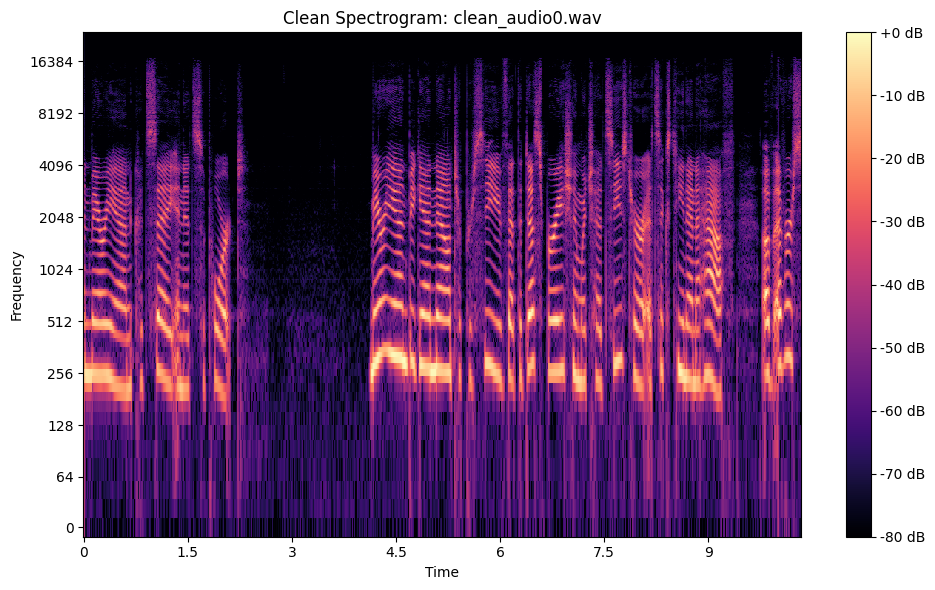

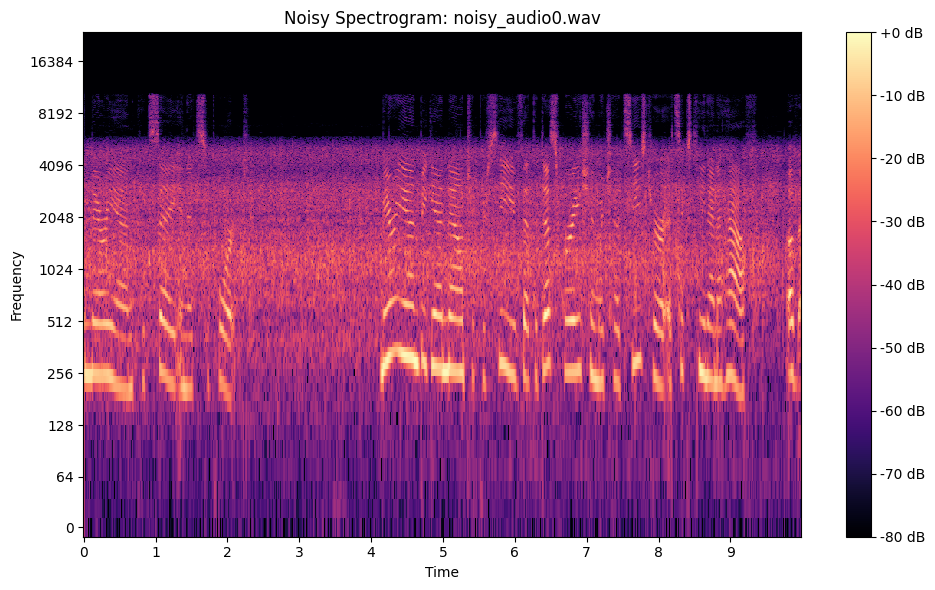

Reconstructing clean audio using original phase...
Reconstructing noisy audio using original phase...


TypeError: resample() takes 1 positional argument but 3 were given

In [ ]:
# WAV SPECTROGRAM CONVERSION HELPER FUNCTIONS

import os
import numpy as np
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt

def load_audio(file_path, sample_rate=48000):
    """
    Load an audio file and return the audio signal and sampling rate.

    Args:
        file_path (str): Path to the audio file.
        sample_rate (int): Target sampling rate.

    Returns:
        tuple: Audio signal and sampling rate.
    """
    audio, sr = librosa.load(file_path, sr=sample_rate)
    return audio, sr

def generate_spectrogram(audio):
    """
    Generate a spectrogram from an audio signal using STFT.

    Args:
        audio (np.ndarray): Audio signal.

    Returns:
        np.ndarray: Complex-valued spectrogram.
    """
    return librosa.stft(audio)

def reconstruct_audio(spectrogram):
    """
    Reconstruct audio from a spectrogram using the inverse STFT.

    Args:
        spectrogram (np.ndarray): Complex-valued spectrogram.

    Returns:
        np.ndarray: Reconstructed audio signal.
    """
    return librosa.istft(spectrogram)

def save_audio(file_path, audio, sample_rate):
    """
    Save an audio signal to a WAV file.

    Args:
        file_path (str): Path to save the WAV file.
        audio (np.ndarray): Audio signal.
        sample_rate (int): Sampling rate.
    """
    sf.write(file_path, audio, sample_rate)

def process_audio_pair(clean_path, noisy_path, sample_rate):
    """
    Process a pair of clean and noisy audio files.

    Args:
        clean_path (str): Path to the clean audio file.
        noisy_path (str): Path to the noisy audio file.
        sample_rate (int): Sampling rate.
    """
    print(f"Processing: {os.path.basename(clean_path)} and {os.path.basename(noisy_path)}")

    # Load audio files
    clean_audio, _ = load_audio(clean_path, sample_rate)
    noisy_audio, _ = load_audio(noisy_path, sample_rate)

    # Generate spectrograms
    clean_spectrogram = generate_spectrogram(clean_audio)
    noisy_spectrogram = generate_spectrogram(noisy_audio)

    # Plot spectrograms
    plot_spectrogram(np.abs(clean_spectrogram), title=f"Clean Spectrogram: {os.path.basename(clean_path)}", sr=sample_rate)
    plot_spectrogram(np.abs(noisy_spectrogram), title=f"Noisy Spectrogram: {os.path.basename(noisy_path)}", sr=sample_rate)

    # Reconstruct and save clean audio
    print("Reconstructing clean audio using original phase...")
    reconstructed_clean = reconstruct_audio(clean_spectrogram)
    save_audio(f"reconstructed_clean_{os.path.basename(clean_path)}", reconstructed_clean, sample_rate)

    # Reconstruct and save noisy audio
    print("Reconstructing noisy audio using original phase...")
    reconstructed_noisy = reconstruct_audio(noisy_spectrogram)
    save_audio(f"reconstructed_noisy_{os.path.basename(noisy_path)}", reconstructed_noisy, sample_rate)

# Parameters
sample_rate = 48000
num_processed_files = 1

# Directories
clean_dir = "../all_audio/clean_audio"
noisy_dir = "../all_audio/noisy_audio"
clean_files = os.listdir(clean_dir)[:num_processed_files]  
noisy_files = os.listdir(noisy_dir)[:num_processed_files]  

# Process each pair of files
for clean_file, noisy_file in zip(clean_files, noisy_files):
    process_audio_pair(
        os.path.join(clean_dir, clean_file),
        os.path.join(noisy_dir, noisy_file),
        sample_rate
    )




In [ ]:
# ATTEMPT TO COVNERT WAV TO SPEC THEN PROCESS INSTEAD OF NPY FILES (Work in progress)

# get spectrograms for all wav files (clean and noisy)
# train test split of spectrograms
# create additional held out set for listenting
# train model on training spectrograms 
# test model on testing spectrograms
# run model on additional held out, set and covnert back to audio for listening

import os
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from tqdm import tqdm  # For tracking progress

# Paths to the feature and label directories
#feature_dir = "../npy_audio/numpy_spectrograms/noisy_audio_np"
#label_dir = "../npy_audio/numpy_spectrograms/clean_audio_np"
# Load all feature and label file paths
#feature_files = sorted(os.listdir(feature_dir))[0:20]
#label_files = sorted(os.listdir(label_dir))[0:20]

num_processed_files = 20
num_listening_examples = 4
feature_dir = "../all_audio/noisy_audio"
label_dir = "../all_audio/clean_audio"

label_files = os.listdir(clean_dir)[:num_processed_files+num_listening_examples]  
feature_files = os.listdir(noisy_dir)[:num_processed_files+num_listening_examples] 
feature_spectrograms = []
label_spectrograms = []

# Convert wav files to spectrograms fro processing
for label_file, feature_file in zip(label_files, feature_files):
    # Load label clean and noisy audio files
    label_audio, sr_label = librosa.load(os.path.join(label_dir, label_file), sr=None)
    feature_audio, sr_feature = librosa.load(os.path.join(feature_dir, feature_file), sr=None)
    #if sr_label != sr_feature: feature_audio = librosa.resample(feature_audio, sr_feature, sr_label)
    
    # Generate spectrograms
    label_spectrogram = librosa.stft(label_audio)
    feature_spectrogram = librosa.stft(feature_audio)
    
    # Convert to magnitude spectrograms
    label_magnitude = np.abs(label_spectrogram)
    feature_magnitude = np.abs(feature_spectrogram)
    
    feature_spectrograms.append(feature_magnitude)
    label_spectrograms.append(label_magnitude)


assert len(feature_files) == len(label_files), "Mismatch between feature and label file counts!"

# Split into training and test sets
train_features, test_features, train_labels, test_labels = train_test_split(
    feature_spectrograms, label_spectrograms, test_size=0.2, random_state=42
)

# Model parameters
freq_bins, time_bins = 128, 860  # Based on the dimensions of your spectrograms
hidden_dim_full = 240            # Hidden dimension for fullband spiking neurons
hidden_dim_sub = 160             # Hidden dimension for sub band spiking neurons
num_steps = 20                   # Number of timesteps for spiking neurons
num_subbands = 3                 # Number of subbands (adjusted for even division)
beta_full = 0.9                  # Decay parameter for Fullband LIF neurons
beta_sub = 0.9                   # Decay parameter for Subband LIF neurons

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = IntegratedModel(freq_bins, time_bins, hidden_dim_full, hidden_dim_sub, num_steps, num_subbands, beta_full, beta_sub).to(device)

# Loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

def train_model_npy(model, features, labels, num_epochs=3):
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for idx in tqdm(range(len(features)), desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
            
            # Load feature and label
            feature_path = os.path.join(feature_dir, features[idx])
            label_path = os.path.join(label_dir, labels[idx])

            noisy_tensor = torch.tensor(np.load(feature_path)).unsqueeze(0).to(device)
            clean_tensor = torch.tensor(np.load(label_path)).unsqueeze(0).to(device)

            clean_time_bins = clean_tensor.shape[2]

            # Forward pass
            optimizer.zero_grad()
            filtered_output = model(noisy_tensor, num_steps=num_steps, clean_time_bins=clean_time_bins)

            # Compute loss
            loss = loss_fn(filtered_output, clean_tensor)
            #loss = si_snr_loss(filtered_output, clean_tensor)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss / len(features):.6f}")

def train_model(model, features, labels, num_epochs=3):
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for idx in tqdm(range(len(features)), desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
            
            noisy_tensor = torch.tensor(features[idx]).unsqueeze(0).to(device)
            clean_tensor = torch.tensor(labels[idx]).unsqueeze(0).to(device)
            clean_time_bins = clean_tensor.shape[2]

            # Forward pass
            optimizer.zero_grad()
            filtered_output = model(noisy_tensor, num_steps=num_steps, clean_time_bins=clean_time_bins)

            # Compute loss
            loss = loss_fn(filtered_output, clean_tensor)
            #loss = si_snr_loss(filtered_output, clean_tensor)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss / len(features):.6f}")

def evaluate_model(model, features, labels):
    losses = []
    with torch.no_grad():
        for idx in tqdm(range(len(features)), desc="Evaluating on Test Set"):
            # Load feature and label
            feature_path = os.path.join(feature_dir, features[idx])
            label_path = os.path.join(label_dir, labels[idx])

            noisy_tensor = torch.tensor(np.load(feature_path)).unsqueeze(0).to(device)
            clean_tensor = torch.tensor(np.load(label_path)).unsqueeze(0).to(device)

            clean_time_bins = clean_tensor.shape[2]

            # Forward pass
            filtered_output = model(noisy_tensor, num_steps=num_steps, clean_time_bins=clean_time_bins)

            # Compute loss
            loss = loss_fn(filtered_output, clean_tensor)
            #loss = si_snr_loss(filtered_output, clean_tensor)
            losses.append(loss.item())

    average_loss = sum(losses) / len(losses)
    print(f"\nAverage Loss (MSE) on Test Set: {average_loss:.6f}")
    return average_loss

train_model(model, train_features, train_labels, num_epochs=3)
evaluate_model(model, test_features, test_labels)



Training Epoch 1/3:   0%|          | 0/19 [00:00<?, ?it/s]


AssertionError: Input dimensions must match model initialization dimensions.